In [ ]:
!nvidia-smi


Wed Dec 11 10:51:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install cvzone
!pip install mediapipe
!pip install tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=77b876cdd5c1883cd4fd21bb88f227dde2c60389389fd69fb310c3c0d661429f
  Stored in directory: /root/.cache/pip/wheels/2c/9f/b3/92e945ac4a71bf727a92463f38155cc5a4fa49c5010b38ec4c
Successfully built cvzone
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 39.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#paths
project_path="/content/drive/MyDrive/50.035 Computer Vision Group Assignment/"
michael_data_folder = "/content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/"
images_only_folder = "/content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Without Landmarks"

data_folder = images_only_folder #note to nada: change path if ur working on diff subset of dataset

In [ ]:
#create csv - note: u only need to run this once btw if u keep retraining the model
csv_path = os.path.join(michael_data_folder,'_imageonly_metadata.csv') #note to nada: change this if ur not training landmarks only
data = []

for filename in os.listdir(data_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        label = filename.split(" (")[0]
        img_path = os.path.join(data_folder, filename)
        data.append({"img_path": img_path, "label": label})

df = pd.DataFrame(data)
print(df.head())

unique_labels = df['label'].unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}
df['numeric_label'] = df['label'].map(label_map)
df = df.drop(columns='label')

df.to_csv(csv_path, index=False)
print("DataFrame created and saved successfully!")



                                            img_path  label
0  /content/drive/MyDrive/50.035 Computer Vision ...  bis_N
1  /content/drive/MyDrive/50.035 Computer Vision ...  bis_N
2  /content/drive/MyDrive/50.035 Computer Vision ...  bis_N
3  /content/drive/MyDrive/50.035 Computer Vision ...  bis_N
4  /content/drive/MyDrive/50.035 Computer Vision ...  bis_N
DataFrame created and saved successfully!


In [ ]:
print(label_map)

{'bis_N': 0, 'bis_O': 1, 'bis_P': 2, 'bis_Q': 3, 'bis_A': 4, 'bis_B': 5, 'bis_R': 6, 'bis_C': 7, 'bis_D': 8, 'bis_E': 9, 'bis_F': 10, 'bis_G': 11, 'bis_S': 12, 'bis_T': 13, 'bis_U': 14, 'bis_V': 15, 'bis_W': 16, 'bis_Y': 17, 'bis_Z': 18, 'bis_H': 19, 'bis_I': 20, 'bis_X': 21, 'bis_K': 22, 'bis_L': 23, 'bis_M': 24, 'tur_S': 25, 'tur_T': 26, 'tur_U': 27, 'tur_V': 28, 'tur_Y': 29, 'tur_Z': 30, 'tur_H': 31, 'tur_I': 32, 'tur_J': 33, 'tur_K': 34, 'tur_L': 35, 'tur_M': 36, 'tur_N': 37, 'tur_O': 38, 'tur_P': 39, 'tur_R': 40, 'tur_A': 41, 'tur_B': 42, 'tur_C': 43, 'tur_D': 44, 'tur_E': 45, 'tur_F': 46, 'tur_G': 47}


In [ ]:
# Load the metadata CSV
metadata = pd.read_csv(csv_path)

# Ensure the 'img_path' column contains full paths to images
metadata['img_path'] = metadata['img_path'].apply(lambda x: os.path.join(data_folder, x))
metadata.head()

,img_path,numeric_label
0,/content/drive/MyDrive/50.035 Computer Vision ...,0
1,/content/drive/MyDrive/50.035 Computer Vision ...,0
2,/content/drive/MyDrive/50.035 Computer Vision ...,0
3,/content/drive/MyDrive/50.035 Computer Vision ...,0
4,/content/drive/MyDrive/50.035 Computer Vision ...,0


In [ ]:
# Split the metadata into training, validation, and test sets
train_df = metadata.sample(frac=0.8, random_state=42)  #80% for train
remaining_df = metadata.drop(train_df.index)
val_df = remaining_df.sample(frac=0.5, random_state=42)  #10% for val
test_df = remaining_df.drop(val_df.index)  #10& for test

# Convert 'numeric_label' to string for compatibility with class_mode='categorical'
train_df['numeric_label'] = train_df['numeric_label'].astype(str)
val_df['numeric_label'] = val_df['numeric_label'].astype(str)
test_df['numeric_label'] = test_df['numeric_label'].astype(str)





In [ ]:
# Paths and labels from the DataFrame
train_paths = train_df['img_path'].values
train_labels = tf.keras.utils.to_categorical(train_df['numeric_label'].astype(int).values)
val_paths = val_df['img_path'].values
val_labels = tf.keras.utils.to_categorical(val_df['numeric_label'].astype(int).values)
test_paths = test_df['img_path'].values
test_labels = tf.keras.utils.to_categorical(test_df['numeric_label'].astype(int).values)

# Preprocessing function for loading and resizing images
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to target size
    image = image / 255.0  # Normalize pixel values
    return image, label

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Load ResNet50 and modify it for the dataset
num_classes = 48

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

for layer in model.layers[-10:]:  # unfreeze last 10 layers
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 260s 103ms/step - accuracy: 0.3525 - loss: 2.7284 - val_accuracy: 0.1671 - val_loss: 3.2370
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9408 - loss: 0.2707 - val_accuracy: 0.8510 - val_loss: 0.7524
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9807 - loss: 0.0904 - val_accuracy: 0.9543 - val_loss: 0.1855
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9787 - loss: 0.0781 - val_accuracy: 0.9820 - val_loss: 0.0745
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9856 - loss: 0.0649 - val_accuracy: 0.9627 - val_loss: 0.1345
Epoch 6/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9937 - loss: 0.0291 - val_accuracy: 0.9832 - val_loss: 0.0473
Epoch 7/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9933 - loss: 0.0321 - val_accuracy: 0.9291 - val_loss: 0.2570
Epoch 8/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9796 - loss: 0.0738 

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Set Accuracy: {test_accuracy}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9167 - loss: 0.5779
Test Set Accuracy: 0.9303721785545349


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step


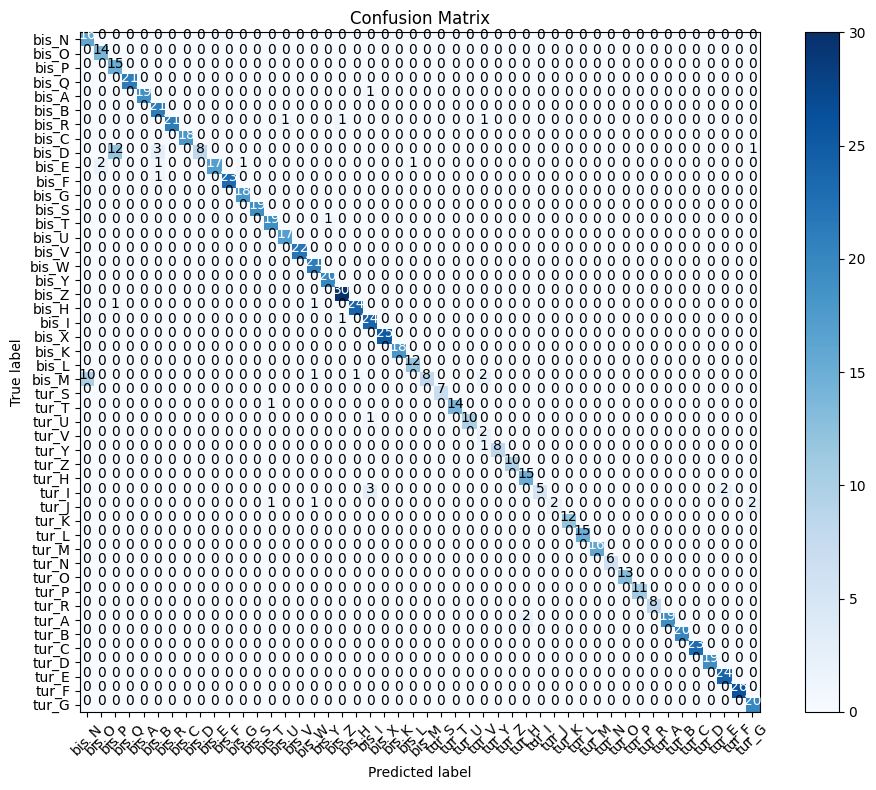

In [ ]:
def get_labels(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label.numpy())
    return np.concatenate(labels)

y_true = get_labels(test_dataset)

y_pred = np.argmax(model.predict(test_dataset), axis=1)

# ensure y_true is a 1D array of class labels (not one-hot encoded)
y_true = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true


cm = confusion_matrix(y_true, y_pred)
class_names = list(label_map.keys())


def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names)
plt.show()



In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       bis_N       0.62      1.00      0.76        16
       bis_O       0.88      1.00      0.93        14
       bis_P       0.54      1.00      0.70        15
       bis_Q       1.00      1.00      1.00        21
       bis_A       1.00      0.95      0.97        20
       bis_B       0.81      1.00      0.89        21
       bis_R       1.00      0.88      0.93        24
       bis_C       1.00      1.00      1.00        18
       bis_D       1.00      0.33      0.50        24
       bis_E       1.00      0.77      0.87        22
       bis_F       1.00      0.96      0.98        24
       bis_G       0.95      1.00      0.97        18
       bis_S       1.00      1.00      1.00        19
       bis_T       0.90      0.95      0.93        20
       bis_U       0.94      1.00      0.97        17
       bis_V       1.00      1.00      1.00        22
       bis_W       0.88      1.00      0.93        21
    

In [ ]:
# Compute F2 score
def fbeta_score(y_true, y_pred, beta=2):
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, beta=beta, average='weighted')
    fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-7)
    return fbeta

f2_score = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 Score: {f2_score}")

F2 Score: 0.9341554642623582


In [ ]:
model_path = os.path.join(project_path,'models/resnet_images_only.h5')
model.save(model_path)
